# CPO Notebook

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import missingno
import optuna
import optuna.visualization as vis

### Parameters and data loading

,EQ CHINA,SX5E,SPX,EQ LAT,EQ PEXJP,EQ CHINA_roc,EQ CHINA_ema200,EQ CHINA_mad,EQ CHINA_kurtosis,EQ CHINA_skew,...,COPPER,BALTIC DRY IDX,CORP EUR,CORP US,GOVIES SW,GOVIES JP,RF_EU,US_EPS,EU_EPS,Govies Euro Volatility
date,,,,,,,,,,,,,,,,,,,,,
2005-04-26,0.009982,-0.001282,-0.008915,0.009045,0.000919,-363.036045,0.000659,0.011193,0.914044,-1.101500,...,2.142857,-0.026144,-0.000033,-0.000977,-0.000112,0.000539,-0.000290,-0.000013,0.000000,-0.000289
2005-04-27,-0.005465,-0.013609,0.004029,-0.010156,-0.001801,-175.828771,0.000598,0.011229,0.599419,-0.838339,...,0.560606,-0.034995,0.000847,0.001529,0.000172,-0.000159,-0.010438,0.000000,0.000000,0.002387
2005-04-28,0.002415,-0.003993,-0.011380,-0.026060,0.001447,-126.932436,0.000616,0.010416,1.366545,-1.148543,...,0.067961,-0.026080,0.001013,0.002969,0.000787,0.000854,-0.004395,0.000000,0.000000,0.000894
2005-05-12,-0.001012,0.007605,-0.010033,-0.014054,-0.002471,-141.891712,0.000633,0.004587,3.487637,1.466252,...,1.000000,-0.025184,-0.000281,0.000983,0.000616,-0.000349,0.002408,-0.000877,0.002015,-0.000474
2005-05-13,-0.011307,0.000478,-0.004580,-0.008143,-0.009447,145.338407,0.000514,0.004989,2.195231,0.870168,...,0.574074,-0.016180,0.000171,0.001309,0.000246,0.000015,-0.006907,0.002085,0.000000,0.001919
2005-05-18,0.000910,0.017581,0.010019,0.022368,0.006513,-67.511278,0.000286,0.007068,1.498638,-0.144697,...,-0.427632,-0.015697,0.000607,0.002799,0.000668,0.001096,0.008174,0.000003,0.000000,0.001546
2005-05-20,0.005558,-0.000439,-0.001511,-0.006063,-0.002757,-837.749710,0.000462,0.007222,0.890135,-0.725963,...,-0.330097,-0.010115,-0.000772,-0.000170,-0.000429,-0.000011,0.007156,0.000000,0.000000,-0.002003
2005-05-23,-0.007709,0.006730,0.003851,0.002375,0.010450,-242.091985,0.000380,0.007259,0.847445,-0.361588,...,-0.391304,-0.007664,0.001745,0.003919,-0.000814,-0.001022,-0.011545,0.000007,0.000000,0.002912
2005-05-24,0.002910,-0.001443,0.000176,0.005116,0.007120,-228.231690,0.000406,0.007673,0.601622,-0.500124,...,-0.785714,-0.018879,0.002001,0.001588,0.001700,0.001859,-0.011081,-0.000270,-0.000197,0.002067


<Axes: >

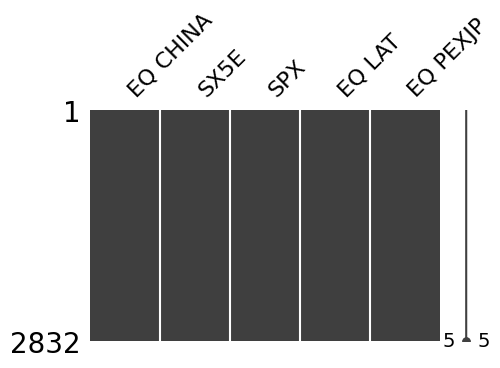

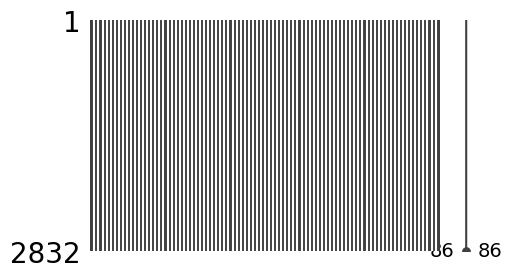

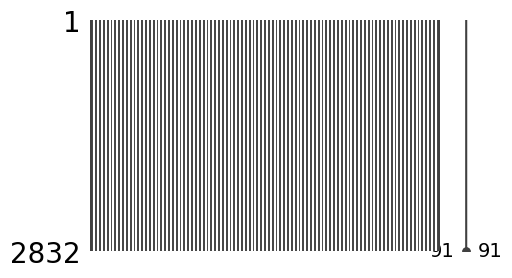

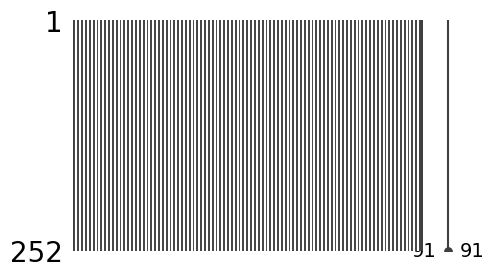

In [141]:
n_assets = 5
N = 50      # combinations
rnd_seed = 42

# Select metric for evaluation 1\2\3 (r2\mean_absolute_error\directional_accuracy)
metric_choice = '2' # Must be in ' '

# Data loading and cleaning
asset_returns = pd.read_csv('asset_returns.csv')
features = pd.read_csv('features.csv')

asset_returns['date'] = pd.to_datetime(asset_returns['date'])
features['date'] = pd.to_datetime(features['date'])

asset_returns = asset_returns.set_index("date")
features = features.set_index("date")

# Removing correlated features
correlations = features.corr().mean()
features_name = (correlations[(correlations < 0.05) & (correlations > -0.05)].index).to_list()
features = features[features_name]

df = asset_returns.merge(features, left_index=True, right_index=True, how="inner")
df = df.dropna()
display(df.head(20))

# We don't consider the last year in order to predict last year's weights
last_year_df = df.iloc[-252:]  # Prende gli ultimi 252 valori
df = df.iloc[:-252]  # Prende tutto il resto

asset_returns = df.iloc[:, :5] # taking first 5 columns as assets returns
features = df.iloc[:, 5:] # taking the rest of the columns as features

# Checking data frames with missingno
missingno.matrix(asset_returns, figsize=(5, 3))
missingno.matrix(features, figsize=(5, 3))
missingno.matrix(df, figsize=(5, 3))
missingno.matrix(last_year_df, figsize=(5, 3))


### Functions

In [20]:
def plot_feature_importance(model, feature_names, model_name):
    
    #Plots and prints the top 10 most important features.
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
    feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False).head(10)

    # Plot the feature importance
    plt.figure(figsize=(8, 5))
    plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="steelblue")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.title(f"Feature Importance - {model_name}")
    plt.gca().invert_yaxis()
    plt.show()

In [21]:
# Rolling Sharpe Ratio calculation
def rolling_sharpe_ratio(returns, window=30, risk_free_rate=0.00007858): # Daily risk-free considering 0.02% annual rate

    excess_returns = returns - risk_free_rate
    rolling_mean = pd.Series(excess_returns).rolling(window).mean()
    rolling_std = pd.Series(excess_returns).rolling(window).std()
    sharpe_ratio = rolling_mean / rolling_std

    # Replace infinities with 0
    sharpe_ratio.replace([np.inf, -np.inf], 0, inplace=True)
    
    # Ensure no NaN values
    sharpe_ratio.fillna(0, inplace=True)

    return sharpe_ratio

In [22]:
# Cross validation function

def time_grouped_cv(model, X, y):
    
    kf = KFold(n_splits=5, shuffle=False)
    scores = []
    
    combined_matrix_filtered = combined_matrix.loc[X.index].copy()
    combined_matrix_filtered['time_step'] = combined_matrix_filtered['time_step'].reset_index(drop=True)
    
    print("\nStarting Time-Grouped Cross-Validation...")
    for fold, (train_idx, test_idx) in enumerate(kf.split(np.unique(combined_matrix_filtered['time_step'])), start=1):

        train_steps = combined_matrix_filtered['time_step'].iloc[train_idx].values
        test_steps = combined_matrix_filtered['time_step'].iloc[test_idx].values
        
        train_mask = combined_matrix_filtered['time_step'].isin(train_steps).values
        test_mask = combined_matrix_filtered['time_step'].isin(test_steps).values       
        
        X_train, X_test = X.loc[train_mask], X.loc[test_mask]
        y_train, y_test = y.loc[train_mask], y.loc[test_mask]        
                
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        # Calculate selected metric
        score = selected_metric_func(y_test, y_pred)
        scores.append(score)
        
    mean_score = np.mean(scores)

    return mean_score


In [23]:
# Based on the chosen metric the function evaluates the model
def evaluate_model(name, model, X_test, y_test, metric):
    y_pred = model.predict(X_test)
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Calculate Directional Accuracy
    y_pred_dir = np.sign(y_pred)
    y_test_dir = np.sign(y_test)
    directional_accuracy = np.mean(y_pred_dir == y_test_dir)
    
    # Display results based on selected metric
    print(f"\nEvaluating {name} Model...")
    print(f"{name} Model Results:")
    print(f"R²: {r2:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"Directional Accuracy: {directional_accuracy:.4f}")
    print("-" * 40)

    # Return selected metric score
    if metric == "R²":
        return r2
    elif metric == "MAE":
        return mae
    elif metric == "DA":
        return directional_accuracy
    else:
        raise ValueError(f"Invalid metric selected: {metric}")


In [24]:
def plot_feature_importances(model, feature_names, model_name):
    
    """Plots and prints the top 10 most important features."""
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
    feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False).head(10)
    
    # Plot the feature importance
    plt.figure(figsize=(8, 5))
    plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="steelblue")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.title(f"Feature Importance - {model_name}")
    plt.gca().invert_yaxis()
    plt.show()
    
def directional_accuracy(y_true, y_pred):
    """Calculates the percentage of times the predicted and actual returns have the same sign."""
    correct_directions = (np.sign(y_true) == np.sign(y_pred)).sum()
    return correct_directions / len(y_true)


In [25]:
def custom_random_search(model, param_grid, X, y, n_iter=10):
    best_score = -np.inf
    best_params = None
    feature_columns = X.columns.tolist()  # Get the feature names directly from X
        
    for i in range(n_iter):
        params = {k: np.random.choice(v) for k, v in param_grid.items()}
        model.set_params(**params)
        
        score = time_grouped_cv(model, X, y)

        if score > best_score:
            best_score = score
            best_params = params
    
    model.set_params(**best_params)    
    model.fit(X, y)
    # Feature Importance Extraction
    if hasattr(model, "feature_importances_"):
        plot_feature_importances(model, feature_columns, model.__class__.__name__)
    return model, best_score, best_params

In [26]:
def directional_accuracy(y_true, y_pred):
    """Calculates the percentage of times the predicted and actual returns have the same sign."""
    correct_directions = (np.sign(y_true) == np.sign(y_pred)).sum()
    return correct_directions / len(y_true)

### Error metric choice

In [27]:
# Map choice to metric
metric_map = {
    "1": ("R²", r2_score),
    "2": ("MAE", mean_absolute_error),
    "3": ("DA", directional_accuracy)
}
selected_metric_name, selected_metric_func = metric_map[metric_choice]
print(f"Selected metric: {selected_metric_name}")

Selected metric: MAE


### Random weights

In [29]:
# Generate random weight combinations using Dirichlet distribution
np.random.seed(rnd_seed)
random_weights = np.random.dirichlet(np.ones(n_assets), size=N)

# Convert to DataFrame
columns = []
for i in range(n_assets):
    columns.append('w'+str(i+1))

portfolio_weights = pd.DataFrame(random_weights, columns=columns)

display(portfolio_weights.head())

,w1,w2,w3,w4,w5
0,0.079825,0.512038,0.223986,0.155297,0.028854
1,0.038624,0.013628,0.458035,0.209311,0.280403
2,0.003617,0.609298,0.310675,0.041510,0.034900
3,0.091305,0.163472,0.335246,0.254855,0.155122
4,0.377441,0.059918,0.137802,0.181977,0.242862


### Combined matrix

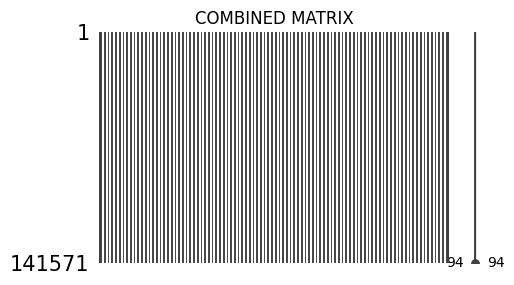

,w1,w2,w3,w4,w5,EQ CHINA_roc,EQ CHINA_ema200,EQ CHINA_mad,EQ CHINA_kurtosis,EQ CHINA_skew,...,CORP US,GOVIES SW,GOVIES JP,RF_EU,US_EPS,EU_EPS,Govies Euro Volatility,portfolio_return,sharpe_ratio,time_step
0,0.018280,0.457421,0.339735,0.025705,0.158859,-363.036045,0.000659,0.011193,0.914044,-1.1015,...,-0.000977,-0.000112,0.000539,-0.00029,-0.000013,0.0,-0.000289,-0.003054,0.559795,0
1,0.308815,0.035403,0.020235,0.086907,0.548640,-363.036045,0.000659,0.011193,0.914044,-1.1015,...,-0.000977,-0.000112,0.000539,-0.00029,-0.000013,0.0,-0.000289,0.004147,0.606887,0
2,0.062984,0.253429,0.325864,0.061663,0.296061,-363.036045,0.000659,0.011193,0.914044,-1.1015,...,-0.000977,-0.000112,0.000539,-0.00029,-0.000013,0.0,-0.000289,-0.001771,0.603348,0
3,0.137907,0.300914,0.301917,0.230801,0.028461,-363.036045,0.000659,0.011193,0.914044,-1.1015,...,-0.000977,-0.000112,0.000539,-0.00029,-0.000013,0.0,-0.000289,0.000413,0.664390,0
4,0.541262,0.116079,0.061949,0.012493,0.268217,-363.036045,0.000659,0.011193,0.914044,-1.1015,...,-0.000977,-0.000112,0.000539,-0.00029,-0.000013,0.0,-0.000289,0.005062,0.711601,0
5,0.358276,0.005295,0.227159,0.081295,0.327975,-363.036045,0.000659,0.011193,0.914044,-1.1015,...,-0.000977,-0.000112,0.000539,-0.00029,-0.000013,0.0,-0.000289,0.002581,0.698030,0
6,0.040227,0.246525,0.102656,0.579531,0.031061,-363.036045,0.000659,0.011193,0.914044,-1.1015,...,-0.000977,-0.000112,0.000539,-0.00029,-0.000013,0.0,-0.000289,0.004441,0.695801,0
7,0.075562,0.021818,0.468476,0.380103,0.054041,-363.036045,0.000659,0.011193,0.914044,-1.1015,...,-0.000977,-0.000112,0.000539,-0.00029,-0.000013,0.0,-0.000289,0.000038,0.646816,0
8,0.233522,0.367891,0.175371,0.163280,0.059936,-363.036045,0.000659,0.011193,0.914044,-1.1015,...,-0.000977,-0.000112,0.000539,-0.00029,-0.000013,0.0,-0.000289,0.001828,0.618963,0
9,0.016030,0.373195,0.378387,0.164471,0.067917,-363.036045,0.000659,0.011193,0.914044,-1.1015,...,-0.000977,-0.000112,0.000539,-0.00029,-0.000013,0.0,-0.000289,-0.002142,0.531001,0


In [ ]:
# Number of time steps (T) and portfolios (N)
T = len(features)
N = len(portfolio_weights)

### Weights-Features matrix ###
# Create the correct NxT matrix
features_repeated = features.loc[features.index.repeat(N)].reset_index(drop=True) # Repeat each row of features N times
portfolio_repeated = pd.DataFrame(   # Tile (cycle) portfolio weights T times so they align with features
    np.tile(portfolio_weights, (T, 1)),
    columns=columns)
combined_matrix = pd.concat([portfolio_repeated, features_repeated], axis=1) # Combine features and weights side by side

### Adding PTF returns ###
# Recalculate portfolio returns using weights and asset returns
portfolio_returns = np.sum(portfolio_repeated.values * asset_returns.loc[asset_returns.index.repeat(N)].values, axis=1)
portfolio_returns_df = pd.DataFrame(portfolio_returns, columns=['portfolio_return'])  # Convert to DataFrame for consistency

combined_matrix['portfolio_return'] = portfolio_returns_df['portfolio_return'].values # Add portfolio returns to the combined matrix

### Adding Sharpe Ratios ###
combined_matrix['sharpe_ratio'] = rolling_sharpe_ratio(combined_matrix['portfolio_return'], window=30) # Calculate Sharpe ratios for all rows (NxT)
combined_matrix['sharpe_ratio'].fillna(0, inplace=True) # Handle NaNs by replacing with zero 
combined_matrix = combined_matrix[combined_matrix['sharpe_ratio'] != 0].reset_index(drop=True) # Remove rows where Sharpe ratio is NaN or zero

# Group rows by time steps
time_steps = np.arange(len(features))
combined_matrix['time_step'] = np.repeat(time_steps, N)[:len(combined_matrix)] # Assign time step groups, repeated N times (so rows for t1-tN are grouped)

### Checks ###
missingno.matrix(combined_matrix,figsize=(5,3), fontsize=12)
plt.title("COMBINED MATRIX")
plt.show()

# Now the combined matrix has the following structure: weights (5), features (86), portfolio returns (1), sharpe ratio (1), time steps (1)
display(combined_matrix.head(10))

# Substitute infinities 
combined_matrix = combined_matrix.replace([float("inf"), float("-inf")]).dropna()

### Prediction Matrix

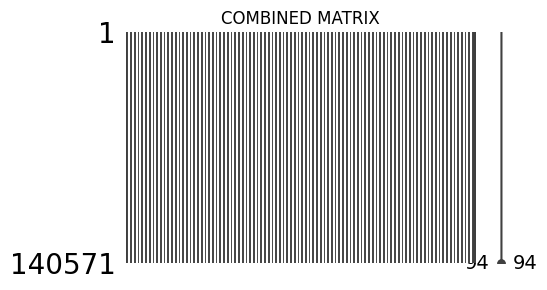

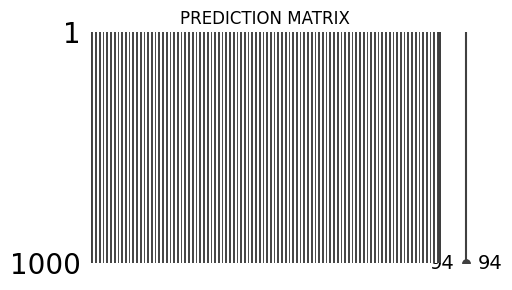

X shape: (140571, 91), y shape: (140571,)
Matching indices: True


In [33]:
# PREDICTION MATRIX
N_P = 20 # how many time step to predict from bottom

predict_matrix = combined_matrix[(-N*N_P):]
combined_matrix = combined_matrix[0:(-N*N_P)]

### Checks ###
missingno.matrix(combined_matrix, figsize=(5,3))
plt.title("COMBINED MATRIX")
plt.show()

missingno.matrix(predict_matrix, figsize=(5,3))
plt.title("PREDICTION MATRIX")
plt.show()

# Prepare features (X) and target (y)
X = combined_matrix.drop(columns=['sharpe_ratio', 'portfolio_return', 'time_step'])
y = combined_matrix['sharpe_ratio']

# Ensure indices of X and y match
print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"Matching indices: {(X.index == y.index).all()}")

# Split data into training and testing sets
split_idx = int(len(X) * 0.7)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

### Model Training

[I 2025-03-27 19:22:41,037] A new study created in memory with name: no-name-f9d06785-828b-4c07-9bc6-5ee884cbd131



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 19:22:42,898] Trial 0 finished with value: 1.2033516648019196 and parameters: {'n_estimators': 267, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_samples': 0.9395978011342135}. Best is trial 0 with value: 1.2033516648019196.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 19:22:45,573] Trial 1 finished with value: 1.128804341786919 and parameters: {'n_estimators': 279, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_samples': 0.8943049774141347}. Best is trial 1 with value: 1.128804341786919.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 19:22:47,782] Trial 2 finished with value: 1.1239818802129355 and parameters: {'n_estimators': 287, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_samples': 0.5191236512380601}. Best is trial 2 with value: 1.1239818802129355.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 19:22:48,958] Trial 3 finished with value: 1.1311299549864986 and parameters: {'n_estimators': 139, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_samples': 0.9554655808315222}. Best is trial 2 with value: 1.1239818802129355.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 19:22:50,839] Trial 4 finished with value: 1.163536293889421 and parameters: {'n_estimators': 258, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_samples': 0.8977517205465331}. Best is trial 2 with value: 1.1239818802129355.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 19:22:52,607] Trial 5 finished with value: 1.2021579134694025 and parameters: {'n_estimators': 258, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_samples': 0.8700260857083718}. Best is trial 2 with value: 1.1239818802129355.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 19:22:53,543] Trial 6 finished with value: 1.1315646104507067 and parameters: {'n_estimators': 114, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_samples': 0.5518274239508205}. Best is trial 2 with value: 1.1239818802129355.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 19:22:56,698] Trial 7 finished with value: 1.1306906061268518 and parameters: {'n_estimators': 279, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_samples': 0.7531450759863245}. Best is trial 2 with value: 1.1239818802129355.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 19:22:57,457] Trial 8 finished with value: 1.2088834563419355 and parameters: {'n_estimators': 102, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_samples': 0.8123765410974704}. Best is trial 2 with value: 1.1239818802129355.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 19:23:00,017] Trial 9 finished with value: 1.1325228237926546 and parameters: {'n_estimators': 287, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_samples': 0.8176550889940515}. Best is trial 2 with value: 1.1239818802129355.


Optuna direction for RF: minimize (metric = MAE)
Best RF hyperparameters: {'n_estimators': 287, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_samples': 0.5191236512380601}


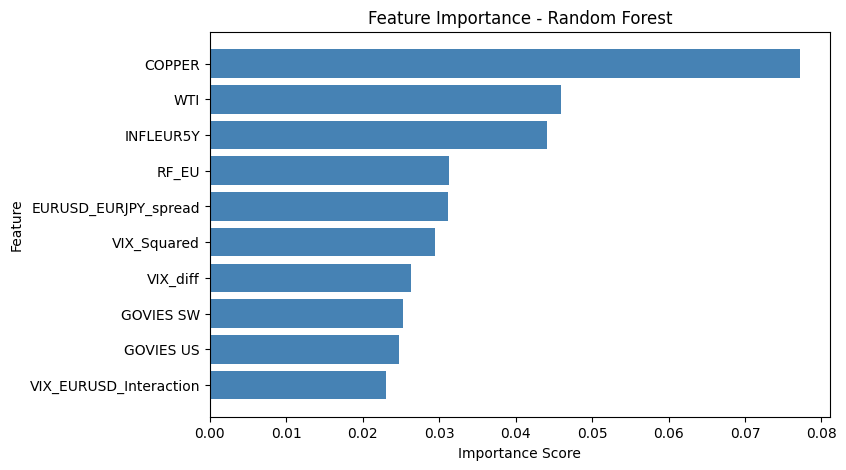

[I 2025-03-27 19:23:13,932] A new study created in memory with name: no-name-301f9f81-9a61-4aa9-8ec6-ff8084047963



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 19:23:25,367] Trial 0 finished with value: 1.1505853322231037 and parameters: {'n_estimators': 160, 'max_depth': 8, 'learning_rate': 0.19017326065697865, 'subsample': 0.9635205441372374, 'min_samples_split': 16, 'min_samples_leaf': 1}. Best is trial 0 with value: 1.1505853322231037.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 19:23:38,847] Trial 1 finished with value: 1.1999794451450196 and parameters: {'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.23878475957250841, 'subsample': 0.764006121270205, 'min_samples_split': 13, 'min_samples_leaf': 1}. Best is trial 0 with value: 1.1505853322231037.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 19:23:50,198] Trial 2 finished with value: 1.128007371816323 and parameters: {'n_estimators': 225, 'max_depth': 7, 'learning_rate': 0.1022935549335884, 'subsample': 0.7123841822233701, 'min_samples_split': 17, 'min_samples_leaf': 1}. Best is trial 2 with value: 1.128007371816323.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 19:24:09,107] Trial 3 finished with value: 1.1519094210054202 and parameters: {'n_estimators': 264, 'max_depth': 8, 'learning_rate': 0.2346318184624144, 'subsample': 0.8183592322415887, 'min_samples_split': 18, 'min_samples_leaf': 3}. Best is trial 2 with value: 1.128007371816323.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 19:24:20,602] Trial 4 finished with value: 1.166611155981253 and parameters: {'n_estimators': 188, 'max_depth': 6, 'learning_rate': 0.09783236714716849, 'subsample': 0.9530433870685273, 'min_samples_split': 12, 'min_samples_leaf': 1}. Best is trial 2 with value: 1.128007371816323.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 19:24:29,956] Trial 5 finished with value: 1.1741172104294875 and parameters: {'n_estimators': 141, 'max_depth': 7, 'learning_rate': 0.16608245766200316, 'subsample': 0.9011166138894888, 'min_samples_split': 14, 'min_samples_leaf': 3}. Best is trial 2 with value: 1.128007371816323.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 19:24:36,789] Trial 6 finished with value: 1.1572132490689544 and parameters: {'n_estimators': 136, 'max_depth': 6, 'learning_rate': 0.02101885259811162, 'subsample': 0.9424512406244678, 'min_samples_split': 16, 'min_samples_leaf': 2}. Best is trial 2 with value: 1.128007371816323.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 19:24:40,472] Trial 7 finished with value: 1.1606722811725008 and parameters: {'n_estimators': 152, 'max_depth': 3, 'learning_rate': 0.01684405732728477, 'subsample': 0.7493963773691873, 'min_samples_split': 12, 'min_samples_leaf': 2}. Best is trial 2 with value: 1.128007371816323.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 19:24:49,536] Trial 8 finished with value: 1.178770503056842 and parameters: {'n_estimators': 158, 'max_depth': 8, 'learning_rate': 0.24811138722293533, 'subsample': 0.7037796131087882, 'min_samples_split': 16, 'min_samples_leaf': 1}. Best is trial 2 with value: 1.128007371816323.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 19:25:04,747] Trial 9 finished with value: 1.13575918321724 and parameters: {'n_estimators': 241, 'max_depth': 9, 'learning_rate': 0.2545926273756629, 'subsample': 0.7064014458101902, 'min_samples_split': 14, 'min_samples_leaf': 3}. Best is trial 2 with value: 1.128007371816323.


Optuna direction for GBR: minimize (metric = MAE)
Best GBR hyperparameters: {'n_estimators': 225, 'max_depth': 7, 'learning_rate': 0.1022935549335884, 'subsample': 0.7123841822233701, 'min_samples_split': 17, 'min_samples_leaf': 1}


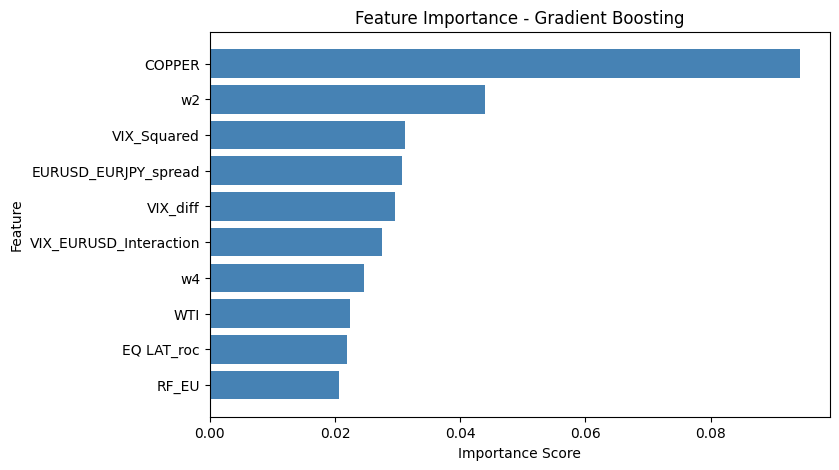

[I 2025-03-27 19:29:12,259] A new study created in memory with name: no-name-388e2d79-8e1f-4c35-95c1-5addb6a046cc



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 19:29:14,353] Trial 0 finished with value: 1.1302523060929504 and parameters: {'n_estimators': 214, 'max_depth': 4, 'learning_rate': 0.12783168621292543, 'subsample': 0.8616460148738597, 'colsample_bytree': 0.7593333213444388, 'gamma': 0.10398146396867196, 'reg_alpha': 0.7662275587662889, 'reg_lambda': 2.6847177391314876}. Best is trial 0 with value: 1.1302523060929504.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 19:29:16,823] Trial 1 finished with value: 1.1671496747307277 and parameters: {'n_estimators': 163, 'max_depth': 7, 'learning_rate': 0.025884557280486664, 'subsample': 0.8057202956183328, 'colsample_bytree': 0.9199138541235691, 'gamma': 0.26558561003420056, 'reg_alpha': 0.5363619295933029, 'reg_lambda': 2.044283505831057}. Best is trial 0 with value: 1.1302523060929504.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 19:29:18,894] Trial 2 finished with value: 1.12457066254634 and parameters: {'n_estimators': 169, 'max_depth': 9, 'learning_rate': 0.2692576008724242, 'subsample': 0.7129216625584698, 'colsample_bytree': 0.705382062952747, 'gamma': 0.17144295179965682, 'reg_alpha': 0.4043711090936125, 'reg_lambda': 2.727475759091492}. Best is trial 2 with value: 1.12457066254634.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 19:29:20,655] Trial 3 finished with value: 1.1479330841956794 and parameters: {'n_estimators': 124, 'max_depth': 4, 'learning_rate': 0.16982068798564454, 'subsample': 0.7963435395224459, 'colsample_bytree': 0.8769610142921176, 'gamma': 0.0905029675792013, 'reg_alpha': 0.8999434345238038, 'reg_lambda': 1.8214144406608979}. Best is trial 2 with value: 1.12457066254634.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 19:29:22,333] Trial 4 finished with value: 1.1594850156872565 and parameters: {'n_estimators': 131, 'max_depth': 3, 'learning_rate': 0.2675370549956907, 'subsample': 0.7977104870187028, 'colsample_bytree': 0.8963238705985047, 'gamma': 0.03846473804925177, 'reg_alpha': 0.263386978281988, 'reg_lambda': 1.125079524689922}. Best is trial 2 with value: 1.12457066254634.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 19:29:26,742] Trial 5 finished with value: 1.1491816077973354 and parameters: {'n_estimators': 269, 'max_depth': 9, 'learning_rate': 0.017308982368975802, 'subsample': 0.8461185782953216, 'colsample_bytree': 0.9450670848064183, 'gamma': 0.20150698346041232, 'reg_alpha': 0.37124166662142966, 'reg_lambda': 2.289065202568163}. Best is trial 2 with value: 1.12457066254634.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 19:29:28,290] Trial 6 finished with value: 1.1290203049723602 and parameters: {'n_estimators': 122, 'max_depth': 4, 'learning_rate': 0.22904941350316702, 'subsample': 0.9619625369382745, 'colsample_bytree': 0.712866665066032, 'gamma': 0.11580999674850202, 'reg_alpha': 0.7528772247693561, 'reg_lambda': 1.9535652098404488}. Best is trial 2 with value: 1.12457066254634.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 19:29:30,537] Trial 7 finished with value: 1.1654889036928595 and parameters: {'n_estimators': 236, 'max_depth': 6, 'learning_rate': 0.2281149756969824, 'subsample': 0.7528833583157929, 'colsample_bytree': 0.9355431132232057, 'gamma': 0.29993253708720374, 'reg_alpha': 0.9057309770535792, 'reg_lambda': 2.5150045017431184}. Best is trial 2 with value: 1.12457066254634.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 19:29:32,943] Trial 8 finished with value: 1.1968062956930052 and parameters: {'n_estimators': 221, 'max_depth': 8, 'learning_rate': 0.2843491718983096, 'subsample': 0.8564576349371714, 'colsample_bytree': 0.950533958715941, 'gamma': 0.013990885338253366, 'reg_alpha': 0.8104210170210119, 'reg_lambda': 2.164669388755394}. Best is trial 2 with value: 1.12457066254634.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 19:29:35,136] Trial 9 finished with value: 1.1476966253267054 and parameters: {'n_estimators': 176, 'max_depth': 8, 'learning_rate': 0.08073607497864321, 'subsample': 0.8548179440659944, 'colsample_bytree': 0.8091612420946014, 'gamma': 0.14432375734232156, 'reg_alpha': 0.5120739240691213, 'reg_lambda': 1.114564319834781}. Best is trial 2 with value: 1.12457066254634.


Optuna direction for XGB: minimize (metric = MAE)
Best XGB hyperparameters: {'n_estimators': 169, 'max_depth': 9, 'learning_rate': 0.2692576008724242, 'subsample': 0.7129216625584698, 'colsample_bytree': 0.705382062952747, 'gamma': 0.17144295179965682, 'reg_alpha': 0.4043711090936125, 'reg_lambda': 2.727475759091492}


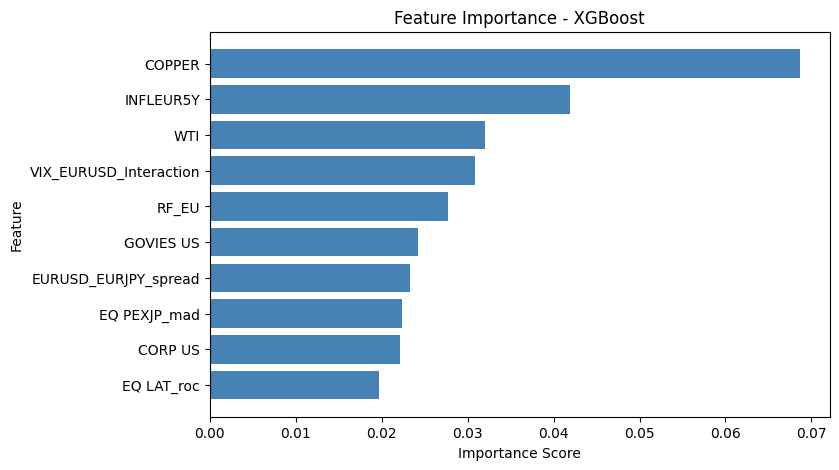


📊 Optuna Visualization for Random Forest



📊 Optuna Visualization for Gradient Boosting



📊 Optuna Visualization for XGBoost



Evaluating Random Forest Model...
Random Forest Model Results:
R²: 0.1228
MSE: 5.8732
MAE: 1.6138
Directional Accuracy: 0.6708
----------------------------------------

Evaluating Gradient Boosting Model...
Gradient Boosting Model Results:
R²: 0.1992
MSE: 5.3616
MAE: 1.5573
Directional Accuracy: 0.6607
----------------------------------------

Evaluating XGBoost Model...
XGBoost Model Results:
R²: 0.1009
MSE: 6.0197
MAE: 1.6806
Directional Accuracy: 0.6328
----------------------------------------


In [35]:
def get_rf_params(trial):
    return {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "max_samples": trial.suggest_float("max_samples", 0.5, 1.0)
    }

def get_xgb_params(trial):
    return {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 0.3),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1, 3.0)
    }

def get_gbr_params(trial):
    return {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4)
    }

def get_optimization_direction(metric_name):
    """Returns 'maximize' or 'minimize' depending on the selected metric."""
    minimize_metrics = ["MAE", "MSE", "RMSE", "max_drawdown"]
    return "minimize" if metric_name.upper() in minimize_metrics else "maximize"

def visualize_optuna_study(study, model_name):

    print(f"\n📊 Optuna Visualization for {model_name}")

    try:
        vis.plot_optimization_history(study).show()
        vis.plot_param_importances(study).show()
        vis.plot_parallel_coordinate(study).show()
        vis.plot_contour(study).show()
    except Exception as e:
        print(f"⚠️ Visualization error for {model_name}: {e}")


def objective(trial, X, y, model_type="rf"):
    if model_type == "rf":
        model = RandomForestRegressor(**get_rf_params(trial), random_state=42)

    elif model_type == "xgb":
        model = XGBRegressor(**get_xgb_params(trial), random_state=42)

    elif model_type == "gbr":
        model = GradientBoostingRegressor(**get_gbr_params(trial), random_state=42)

    else:
        raise ValueError("Unknown model type")

    score = time_grouped_cv(model, X, y)
    return score

##RF

optuna_direction = get_optimization_direction(selected_metric_name)
study_rf = optuna.create_study(direction=optuna_direction)
study_rf.optimize(lambda trial: objective(trial, X_train, y_train, model_type="rf"), n_trials=10)
print(f"Optuna direction for RF: {optuna_direction} (metric = {selected_metric_name})")

print("Best RF hyperparameters:", study_rf.best_params)
rf_best_model = RandomForestRegressor(**study_rf.best_params, random_state=42)
rf_best_model.fit(X_train, y_train)
plot_feature_importances(rf_best_model, X_train.columns, "Random Forest")

##GBR

optuna_direction = get_optimization_direction(selected_metric_name)
study_gbr = optuna.create_study(direction=optuna_direction)
study_gbr.optimize(lambda trial: objective(trial, X_train, y_train, model_type="gbr"), n_trials=10)
print(f"Optuna direction for GBR: {optuna_direction} (metric = {selected_metric_name})")

print("Best GBR hyperparameters:", study_gbr.best_params)
gbr_best_model = GradientBoostingRegressor(**study_gbr.best_params, random_state=42)
gbr_best_model.fit(X_train, y_train)
plot_feature_importances(gbr_best_model, X_train.columns, "Gradient Boosting")

##XGB

optuna_direction = get_optimization_direction(selected_metric_name)
study_xgb = optuna.create_study(direction=optuna_direction)
study_xgb.optimize(lambda trial: objective(trial, X_train, y_train, model_type="xgb"), n_trials=10)
print(f"Optuna direction for XGB: {optuna_direction} (metric = {selected_metric_name})")

print("Best XGB hyperparameters:", study_xgb.best_params)
xgb_best_model = XGBRegressor(**study_xgb.best_params, random_state=42)
xgb_best_model.fit(X_train, y_train)
plot_feature_importances(xgb_best_model, X_train.columns, "XGBoost")

studies = {
    "Random Forest": study_rf,
    "Gradient Boosting": study_gbr,
    "XGBoost": study_xgb
}

for name, study in studies.items():
    visualize_optuna_study(study, name)

rf_metrics = evaluate_model("Random Forest", rf_best_model, X_test, y_test,selected_metric_name)
gbr_metrics = evaluate_model("Gradient Boosting", gbr_best_model, X_test, y_test,selected_metric_name)
xgb_metrics = evaluate_model("XGBoost", xgb_best_model, X_test, y_test,selected_metric_name)


### Prediction

In [39]:
# prediction
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
X_pred = predict_matrix.drop(columns=['sharpe_ratio', 'portfolio_return', 'time_step'])

yhat_rf = rf_best_model.predict(X_pred)
yhat_gbr = gbr_best_model.predict(X_pred)
yhat_xgb = xgb_best_model.predict(X_pred)

X_pred['yhat_rf'] = yhat_rf
X_pred['yhat_gbr'] = yhat_gbr
X_pred['yhat_xgb'] = yhat_xgb

W_rf = X_pred[X_pred['yhat_rf'] == X_pred['yhat_rf'].max()].iloc[:,0:5].iloc[0]
W_gbr = X_pred[X_pred['yhat_gbr'] == X_pred['yhat_gbr'].max()].iloc[:,0:5].iloc[0]
W_xgb = X_pred[X_pred['yhat_xgb'] == X_pred['yhat_xgb'].max()].iloc[:,0:5].iloc[0]


print("\n Final Recommended Portfolios:")

print("\n📌 Random Forest Portfolio Weights:")
print(W_rf)

print("\n📌 Gradient Boosting Portfolio Weights:")
print(W_gbr)

print("\n📌 XGBoost Portfolio Weights:")
print(W_xgb)


 Final Recommended Portfolios:

📌 Random Forest Portfolio Weights:
w1    0.079825
w2    0.512038
w3    0.223986
w4    0.155297
w5    0.028854
Name: 141121, dtype: float64

📌 Gradient Boosting Portfolio Weights:
w1    0.006667
w2    0.077210
w3    0.785951
w4    0.003662
w5    0.126510
Name: 141162, dtype: float64

📌 XGBoost Portfolio Weights:
w1    0.358276
w2    0.005295
w3    0.227159
w4    0.081295
w5    0.327975
Name: 141155, dtype: float64


We reconstruct the combined matrix with the last year's data that the model hasn't seen

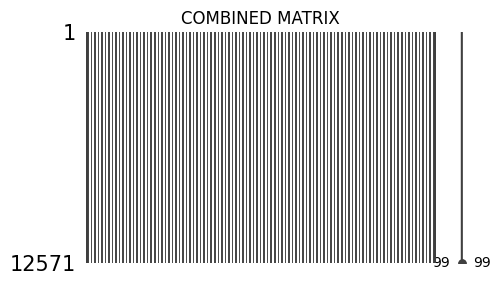

,w1,w2,w3,w4,w5,EQ CHINA,SX5E,SPX,EQ LAT,EQ PEXJP,...,CORP US,GOVIES SW,GOVIES JP,RF_EU,US_EPS,EU_EPS,Govies Euro Volatility,portfolio_return,sharpe_ratio,time_step
0,0.018280,0.457421,0.339735,0.025705,0.158859,-0.014236,-0.009173,-0.001968,-0.003648,-0.008793,...,-0.002953,-0.002459,0.001185,0.009792,4.477639e-07,-0.000003,-0.000062,-0.006616,-3.963659,0
1,0.308815,0.035403,0.020235,0.086907,0.548640,-0.014236,-0.009173,-0.001968,-0.003648,-0.008793,...,-0.002953,-0.002459,0.001185,0.009792,4.477639e-07,-0.000003,-0.000062,-0.009902,-3.945674,0
2,0.062984,0.253429,0.325864,0.061663,0.296061,-0.014236,-0.009173,-0.001968,-0.003648,-0.008793,...,-0.002953,-0.002459,0.001185,0.009792,4.477639e-07,-0.000003,-0.000062,-0.006691,-4.121567,0
3,0.137907,0.300914,0.301917,0.230801,0.028461,-0.014236,-0.009173,-0.001968,-0.003648,-0.008793,...,-0.002953,-0.002459,0.001185,0.009792,4.477639e-07,-0.000003,-0.000062,-0.006410,-4.101067,0
4,0.541262,0.116079,0.061949,0.012493,0.268217,-0.014236,-0.009173,-0.001968,-0.003648,-0.008793,...,-0.002953,-0.002459,0.001185,0.009792,4.477639e-07,-0.000003,-0.000062,-0.011296,-4.092251,0
5,0.358276,0.005295,0.227159,0.081295,0.327975,-0.014236,-0.009173,-0.001968,-0.003648,-0.008793,...,-0.002953,-0.002459,0.001185,0.009792,4.477639e-07,-0.000003,-0.000062,-0.008777,-4.094625,0
6,0.040227,0.246525,0.102656,0.579531,0.031061,-0.014236,-0.009173,-0.001968,-0.003648,-0.008793,...,-0.002953,-0.002459,0.001185,0.009792,4.477639e-07,-0.000003,-0.000062,-0.005423,-3.931278,0
7,0.075562,0.021818,0.468476,0.380103,0.054041,-0.014236,-0.009173,-0.001968,-0.003648,-0.008793,...,-0.002953,-0.002459,0.001185,0.009792,4.477639e-07,-0.000003,-0.000062,-0.004060,-3.662653,0
8,0.233522,0.367891,0.175371,0.163280,0.059936,-0.014236,-0.009173,-0.001968,-0.003648,-0.008793,...,-0.002953,-0.002459,0.001185,0.009792,4.477639e-07,-0.000003,-0.000062,-0.008167,-3.675323,0
9,0.016030,0.373195,0.378387,0.164471,0.067917,-0.014236,-0.009173,-0.001968,-0.003648,-0.008793,...,-0.002953,-0.002459,0.001185,0.009792,4.477639e-07,-0.000003,-0.000062,-0.005594,-3.681207,0


In [142]:
# Number of time steps (T) and portfolios (N)
T = len(features)
N = len(portfolio_weights)

### Weights-Features matrix ###
# Create the correct NxT matrix
last_year_df = last_year_df.reset_index(drop=True)
last_year_df = last_year_df.loc[last_year_df.index.repeat(N)].reset_index(drop=True) # Repeat each row of features N times
portfolio_repeated = pd.DataFrame(   # Tile (cycle) portfolio weights T times so they align with features
    np.tile(portfolio_weights, (T, 1)),
    columns=columns)
last_year_matrix = pd.concat([portfolio_repeated, last_year_df], axis=1).dropna() # Combine features and weights side by side

### Adding PTF returns ###
# Recalculate portfolio returns using weights and asset returns
portfolio_returns = np.sum(last_year_matrix.iloc[:,:5].values * last_year_df[asset_returns.columns.to_list()], axis=1)
portfolio_returns_df = pd.DataFrame(portfolio_returns, columns=['portfolio_return'])  # Convert to DataFrame for consistency

last_year_matrix['portfolio_return'] = portfolio_returns_df['portfolio_return'].values # Add portfolio returns to the combined matrix

### Adding Sharpe Ratios ###
last_year_matrix['sharpe_ratio'] = rolling_sharpe_ratio(last_year_matrix['portfolio_return'], window=30) # Calculate Sharpe ratios for all rows (NxT)
last_year_matrix['sharpe_ratio'].fillna(0, inplace=True) # Handle NaNs by replacing with zero 
last_year_matrix = last_year_matrix[last_year_matrix['sharpe_ratio'] != 0].reset_index(drop=True) # Remove rows where Sharpe ratio is NaN or zero

# Group rows by time steps
time_steps = np.arange(len(features))
last_year_matrix['time_step'] = np.repeat(time_steps, N)[:len(last_year_matrix)] # Assign time step groups, repeated N times (so rows for t1-tN are grouped)

### Checks ###
missingno.matrix(last_year_matrix,figsize=(5,3), fontsize=12)
plt.title("COMBINED MATRIX")
plt.show()

# Now the combined matrix has the following structure: weights (5), features (86), portfolio returns (1), sharpe ratio (1), time steps (1)
display(last_year_matrix.head(10))

# Substitute infinities 
last_year_matrix = last_year_matrix.replace([float("inf"), float("-inf")]).dropna()

In [143]:
# we split our last year matrix into 12 months of 20 days each

columns_to_drop = ['sharpe_ratio', 'portfolio_return']
columns_to_drop += asset_returns.columns.to_list()
last_year_matrix = last_year_matrix.drop(columns=columns_to_drop)

X_pred_ = {}

for i in range(1,13):
    X_pred_[i] = last_year_matrix[(last_year_matrix["time_step"] < (i*20)) & (last_year_matrix["time_step"] >= ((i-1)*20))].drop(columns=['time_step'])

X_pred_[11]

,w1,w2,w3,w4,w5,EQ CHINA_roc,EQ CHINA_ema200,EQ CHINA_mad,EQ CHINA_kurtosis,EQ CHINA_skew,...,COPPER,BALTIC DRY IDX,CORP EUR,CORP US,GOVIES SW,GOVIES JP,RF_EU,US_EPS,EU_EPS,Govies Euro Volatility
10000,0.018280,0.457421,0.339735,0.025705,0.158859,525.390273,0.000218,0.007075,0.994404,-0.525427,...,-0.007778,-0.013225,0.001207,0.001065,0.002110,-0.001270,-0.005875,0.0,0.014125,0.002579
10001,0.308815,0.035403,0.020235,0.086907,0.548640,525.390273,0.000218,0.007075,0.994404,-0.525427,...,-0.007778,-0.013225,0.001207,0.001065,0.002110,-0.001270,-0.005875,0.0,0.014125,0.002579
10002,0.062984,0.253429,0.325864,0.061663,0.296061,525.390273,0.000218,0.007075,0.994404,-0.525427,...,-0.007778,-0.013225,0.001207,0.001065,0.002110,-0.001270,-0.005875,0.0,0.014125,0.002579
10003,0.137907,0.300914,0.301917,0.230801,0.028461,525.390273,0.000218,0.007075,0.994404,-0.525427,...,-0.007778,-0.013225,0.001207,0.001065,0.002110,-0.001270,-0.005875,0.0,0.014125,0.002579
10004,0.541262,0.116079,0.061949,0.012493,0.268217,525.390273,0.000218,0.007075,0.994404,-0.525427,...,-0.007778,-0.013225,0.001207,0.001065,0.002110,-0.001270,-0.005875,0.0,0.014125,0.002579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10995,0.352781,0.484890,0.081962,0.024968,0.055398,-107.065829,-0.000227,0.009452,1.958232,1.254096,...,0.006846,0.004770,0.000547,-0.004743,-0.003819,-0.009228,0.004570,0.0,0.001044,0.000094
10996,0.112444,0.343924,0.397923,0.001408,0.144300,-107.065829,-0.000227,0.009452,1.958232,1.254096,...,0.006846,0.004770,0.000547,-0.004743,-0.003819,-0.009228,0.004570,0.0,0.001044,0.000094
10997,0.128816,0.059885,0.030442,0.098210,0.682646,-107.065829,-0.000227,0.009452,1.958232,1.254096,...,0.006846,0.004770,0.000547,-0.004743,-0.003819,-0.009228,0.004570,0.0,0.001044,0.000094
10998,0.061423,0.115086,0.191023,0.071113,0.561354,-107.065829,-0.000227,0.009452,1.958232,1.254096,...,0.006846,0.004770,0.000547,-0.004743,-0.003819,-0.009228,0.004570,0.0,0.001044,0.000094


In [ ]:
monthly_weights_rf = pd.DataFrame(columns=['w1', 'w2', 'w3', 'w4', 'w5'])
monthly_weights_gbr = pd.DataFrame(columns=['w1', 'w2', 'w3', 'w4', 'w5'])
monthly_weights_xgb = pd.DataFrame(columns=['w1', 'w2', 'w3', 'w4', 'w5'])

for i in range(1,13):

    X_pred = X_pred_[i]

    yhat_rf = rf_best_model.predict(X_pred)
    yhat_gbr = gbr_best_model.predict(X_pred)
    yhat_xgb = xgb_best_model.predict(X_pred)

    X_pred['yhat_rf'] = yhat_rf
    X_pred['yhat_gbr'] = yhat_gbr
    X_pred['yhat_xgb'] = yhat_xgb

    W_rf = X_pred[X_pred['yhat_rf'] == X_pred['yhat_rf'].max()].iloc[0,0:5]
    monthly_weights_rf.loc[i-1] = W_rf.values

    W_gbr = X_pred[X_pred['yhat_gbr'] == X_pred['yhat_gbr'].max()].iloc[0,0:5]
    monthly_weights_gbr.loc[i-1] = W_gbr.values

    W_xgb = X_pred[X_pred['yhat_xgb'] == X_pred['yhat_xgb'].max()].iloc[0,0:5]
    monthly_weights_xgb.loc[i-1] = W_xgb.values

In [176]:
asset_returns = pd.read_csv('asset_returns.csv')
asset_returns = asset_returns.iloc[-240:,:]
asset_returns = asset_returns.drop(columns=["date"]).reset_index(drop=True)

In [ ]:
monthly_weights_rf = monthly_weights_rf.loc[monthly_weights_rf.index.repeat(20)].reset_index(drop=True)
monthly_weights_gbr = monthly_weights_gbr.loc[monthly_weights_gbr.index.repeat(20)].reset_index(drop=True)
monthly_weights_xgb = monthly_weights_xgb.loc[monthly_weights_xgb.index.repeat(20)].reset_index(drop=True)

# portoflios returns

ptf_returns_rf = np.sum(monthly_weights_rf.values * asset_returns.values, axis=1)
ptf_returns_gbr = np.sum(monthly_weights_gbr.values * asset_returns.values, axis=1)
ptf_returns_xgb = np.sum(monthly_weights_xgb.values * asset_returns.values, axis=1)

In [199]:
msci_w = pd.read_excel('data.xlsx', header=3)
msci_w = msci_w['MXWO']
msci_w = msci_w.iloc[-241:].pct_change().dropna().reset_index()
msci_w

,index,MXWO
0,5117,0.008043
1,5118,-0.000523
2,5119,-0.007459
3,5120,0.005942
4,5121,0.010197
...,...,...
235,5352,0.000158
236,5353,-0.011266
237,5354,0.006010
238,5355,-0.002033


<Figure size 1000x600 with 0 Axes>

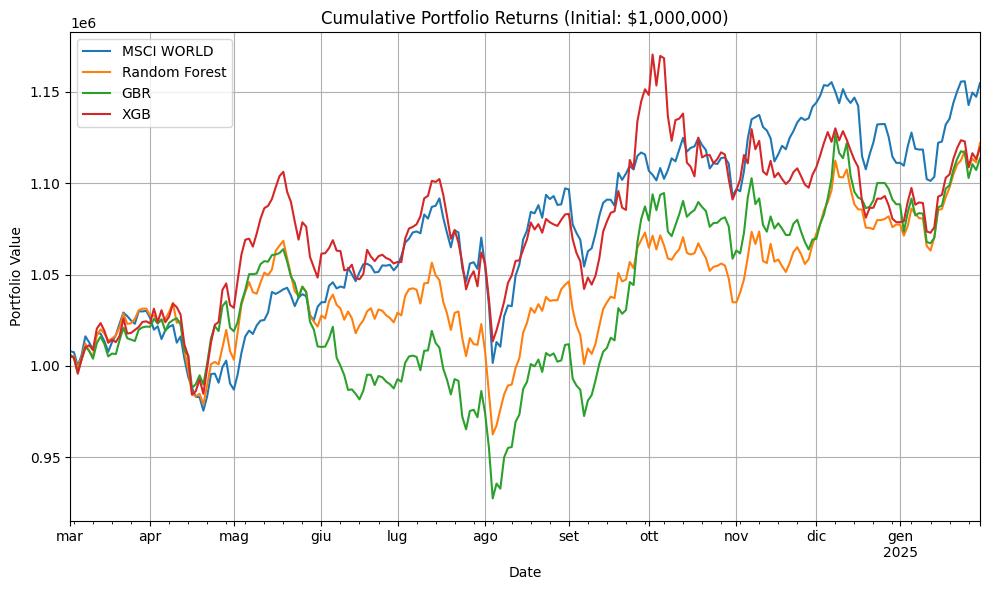

In [224]:
msci_w = pd.read_excel('data.xlsx', header=3)
msci_w = msci_w[['date', 'MXWO']]
msci_w.rename(columns={'MXWO': 'MSCI WORLD'}, inplace=True)
msci_w['date'] = pd.to_datetime(msci_w['date'])
msci_w.set_index('date', inplace=True)
msci_w = msci_w.iloc[-241:].pct_change().dropna()

initial_investment = 1_000_000

cumulative_rf = (1 + ptf_returns_rf).cumprod() * initial_investment
cumulative_gbr = (1 + ptf_returns_gbr).cumprod() * initial_investment
cumulative_xgb = (1 + ptf_returns_xgb).cumprod() * initial_investment
cumulative_msci = (1 + msci_w).cumprod() * initial_investment

# Convertiamo le serie in DataFrame per assegnare l'indice
cumulative_rf = pd.DataFrame(cumulative_rf, index=msci_w.index, columns=["Random Forest"])
cumulative_gbr = pd.DataFrame(cumulative_gbr, index=msci_w.index, columns=["GBR"])
cumulative_xgb = pd.DataFrame(cumulative_xgb, index=msci_w.index, columns=["XGB"])
cumulative_msci = pd.DataFrame(cumulative_msci, index=msci_w.index, columns=["MSCI WORLD"])  # <--- RINOMINATO QUI

# Uniamo tutto in un unico DataFrame per plottarlo più facilmente
df_plot = pd.concat([cumulative_msci, cumulative_rf, cumulative_gbr, cumulative_xgb], axis=1)

# Plot
plt.figure(figsize=(10, 6))
df_plot.plot(figsize=(10,6))

plt.title("Cumulative Portfolio Returns (Initial: $1,000,000)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend(df_plot.columns)
plt.grid(True)
plt.tight_layout()
plt.show()


In [243]:
#produce final matrix for the portfolio 
#sharpe, max drawdown, final protfolio value 

###EVALUATION OF THE PORTFOLIO####

def evaluate_portfolio(ptf_returns):
    # Sharpe Ratio
    sharpe_ratio = (
        np.nan if ptf_returns.std() == 0
        else ptf_returns.mean() / ptf_returns.std()
    )

    # Cumulative performance scaled by investment
    cumulative = (1 + ptf_returns).cumprod() * initial_investment

    # Final portfolio value = last cumulative value
    final_value = cumulative[-1]

    # Max drawdown
    drawdown = cumulative / pd.Series(cumulative).cummax() - 1
    drawdown = drawdown.clip(lower=-0.99)  # prevent wild drawdowns
    max_drawdown = drawdown.min()

    return final_value, sharpe_ratio, max_drawdown, cumulative

# Evaluate all models
models = [
    ("Random Forest", ptf_returns_rf),
    ("GBR", ptf_returns_gbr),
    ("XGB", ptf_returns_xgb),
    ("MSCI WORLD", msci_w['MSCI WORLD'].values)
]

results = {}

# Itera sui modelli e calcola le metriche
for name, ptf in models:
    final_val, sharpe, mdd, curve = evaluate_portfolio(ptf)
    results[name] = {
        "Final Value": final_val,
        "Sharpe Ratio": sharpe,
        "Max Drawdown": mdd,
        "Cumulative": curve
    }

# Summary table
performance_df = pd.DataFrame({
    model: {
        "Final Value": res["Final Value"],
        "Sharpe Ratio": res["Sharpe Ratio"],
        "Max Drawdown": res["Max Drawdown"]
    }
    for model, res in results.items()
}).T

print("\n📊 Portfolio Evaluation Summary:")
print(performance_df.round(4))


📊 Portfolio Evaluation Summary:
                Final Value  Sharpe Ratio  Max Drawdown
Random Forest  1.121891e+06        0.0732       -0.0991
GBR            1.113517e+06        0.0610       -0.1281
XGB            1.119516e+06        0.0622       -0.0838
MSCI WORLD     1.154708e+06        0.0900       -0.0824


____________________________________________________________________________________________________

____________________________________________________________________________________________________

____________________________________________________________________________________________________

### RandomSearch

In [ ]:
"""
# Define hyperparameter grids

gbr_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10, 20, 30],    # Added regularization
    'min_samples_leaf': [1, 2, 4]               # Added regularization
}

xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],              # Added regularization
    'gamma': [0, 0.1, 0.2],                     # Added regularization
    'reg_alpha': [0, 0.1, 0.5],                 # L1 regularization (lasso)
    'reg_lambda': [1, 1.5, 2.0, 3.0]            # L2 regularization (ridge)
}

rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],           # Added regularization
    'max_samples': [0.5, 0.75, 1.0]             # Added regularization
}

# Define hyperparameter grids

gbr_params = {
    'n_estimators': [200, 300, 500],  # Maggiore capacità di apprendimento
    'max_depth': [10, 15, 20],  # Modelli più complessi
    'learning_rate': [0.05, 0.1, 0.2],  # Step più grandi per velocizzare il training
    'subsample': [0.8, 0.9, 1.0],  # Usa più dati per ogni albero
    'min_samples_split': [2, 3, 5],  # Permetti più split
    'min_samples_leaf': [1, 2],  # Permetti foglie più piccole
}

xgb_params = {
    'n_estimators': [300, 500, 700],  # Più alberi per una maggiore capacità predittiva
    'max_depth': [10, 15, 20],  # Più profondità per un maggiore fitting
    'learning_rate': [0.05, 0.1, 0.2],  # Step più aggressivi
    'colsample_bytree': [0.8, 0.9, 1.0],  # Usa quasi tutte le feature in ogni albero
    'subsample': [0.9, 1.0],  # Usa tutti i dati per ogni albero
    'min_child_weight': [1, 2],  # Meno restrizioni sugli split
    'gamma': [0, 0.05, 0.1],  # Ridotto per meno regolarizzazione
    'reg_alpha': [0, 0.01, 0.05],  # Quasi senza L1 (lasso)
    'reg_lambda': [0.5, 1, 1.5],  # Ridotto per meno L2 (ridge)
}

rf_params = {
    'n_estimators': [500, 700, 1000],  # Più alberi per ridurre la varianza
    'max_depth': [20, 30, None],  # Nessun limite di profondità per modelli complessi
    'min_samples_split': [2, 3, 5],  # Più suddivisioni
    'min_samples_leaf': [1, 2],  # Permetti foglie più piccole
    'max_features': [None, 'sqrt', 'log2'],  # Usa tutte le feature quando possibile
    'max_samples': [0.75, 1.0],  # Usa quasi tutti i dati per ogni albero
}

gbr = GradientBoostingRegressor(random_state=rnd_seed)
rf = RandomForestRegressor(random_state=rnd_seed)
xgb = XGBRegressor(random_state=rnd_seed)


# Random search with time grouping
rf_best_model, rf_best_score, rf_best_params = custom_random_search(rf, rf_params, X_train, y_train)
gbr_best_model, gbr_best_score, gbr_best_params = custom_random_search(gbr, gbr_params, X_train, y_train)
xgb_best_model, xgb_best_score, xgb_best_params = custom_random_search(xgb, xgb_params, X_train, y_train)


print("\nBest Random Forest hyperparameters:", rf_best_params)
print("Regularization params (RF): max_features={}, max_samples={}".format(
    rf_best_params.get('max_features'), rf_best_params.get('max_samples')))

print("\nBest Gradient Boosting hyperparameters:", gbr_best_params)
print("Regularization params (GBR): min_samples_split={}, min_samples_leaf={}".format(
    gbr_best_params.get('min_samples_split'), gbr_best_params.get('min_samples_leaf')))

print("\nBest XGBoost hyperparameters:", xgb_best_params)
print("Regularization params (XGB): min_child_weight={}, gamma={}, reg_alpha={}, reg_lambda={}".format(
    xgb_best_params.get('min_child_weight'), 
    xgb_best_params.get('gamma'),
    xgb_best_params.get('reg_alpha'),
    xgb_best_params.get('reg_lambda')))

_ = evaluate_model("Random Forest", rf_best_model, X_test, y_test,metric=selected_metric_name)
_ = evaluate_model("Gradient Boosting", gbr_best_model, X_test, y_test,metric=selected_metric_name)
_ = evaluate_model("XGBoost", xgb_best_model, X_test, y_test,metric=selected_metric_name)

# prediction
X_pred = predict_matrix.drop(columns=['sharpe_ratio', 'portfolio_return', 'time_step'])

yhat_rf = rf_best_model.predict(X_pred)
yhat_gbr = gbr_best_model.predict(X_pred)
yhat_xgb = xgb_best_model.predict(X_pred)

X_pred['yhat_rf'] = yhat_rf
X_pred['yhat_gbr'] = yhat_gbr
X_pred['yhat_xgb'] = yhat_xgb


W_rf = X_pred[X_pred['yhat_rf'] == X_pred['yhat_rf'].max()].iloc[:, 0:5]
W_gbr = X_pred[X_pred['yhat_gbr'] == X_pred['yhat_gbr'].max()].iloc[:, 0:5]
W_xgb = X_pred[X_pred['yhat_xgb'] == X_pred['yhat_xgb'].max()].iloc[:, 0:5]

display(W_rf)
display(W_gbr)  
display(W_xgb)
"""